In [1]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict
import progressbar
import random
import cv2
from scipy import stats


In [2]:
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

In [3]:
# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    #i = 0
    for tm,cl in zip(findAllFile(tm_folder),findAllFile(cl_folder)):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.loadtxt(tm,delimiter=",")
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        AM[OM >= epsilon] = 1
        AM[OM < epsilon] = 0
        
        # Get graph from AM, no-direct and no-weight graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        # Make sure the order of cowlist is the same as the row name!
        mapping = dict(zip(G_AM_temp, cowlist))
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_binary,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_binary=AM,Graph=G_AM)
        #i = i + 1
        dict_list.append(data_dict)
    #print(i)
    print('The length of the list: ',len(dict_list))
    return dict_list

In [4]:
def cowlist_import(cl_folder):
    cow_lists = []
    for cl in findAllFile(cl_folder):
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        cow_lists.append(cowlist)
    return cow_lists

In [5]:
# This part is used to process the time matrices
tm_folder = './time_matrix'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)
cow_lists = cowlist_import(cl_folder)

The length of the list:  14


In [6]:
def own_degree_hist(G,max_degree):
    degrees = [G.degree(n) for n in G.nodes()]
    hist, bins = np.histogram(degrees, bins = max_degree, range = (0, max_degree))
    return hist
    

In [7]:
def top_centrality_count(G, num_top):
    cent = nx.degree_centrality(G)
    array = np.array(list(cent.items()))[:,1]
    top_idx = np.argsort(array)[-num_top:]
    print(top_idx)
    return top_idx

In [10]:
num_to_look_at = 5
top_cows = np.zeros((num_to_look_at, len(data_dict_list)))
for i in range(len(data_dict_list)):
    indexes = top_centrality_count(data_dict_list[i].get('Graph'), num_to_look_at)
    cow_list = cow_lists[i]
    for j, index in enumerate(indexes):
        top_cows[j, i] = cow_list[index]
np.savetxt('./community/Centr/center.csv', top_cows, delimiter=",")


[  3  68 149  25  89]
[ 94  81 150  78 134]
[202 185  57 128 138]
[189 204 152 164 172]
[  4  63  53 156 174]
[195 110  59 157 101]
[ 86  84  10 180 107]
[188 118  86 145  83]
[69 42 10 14 44]
[ 42  19 200  47  80]
[ 17 125 163  96  34]
[ 72 191 184  70  82]
[168  22 101 138  29]
[107 152 146  88  35]


Average apperances: 1.8421052631578947
Expected appearances if random = 
Average apperances when removed ones: 2.8823529411764706, which are 17 out of 38


(array([21., 10.,  0.,  4.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

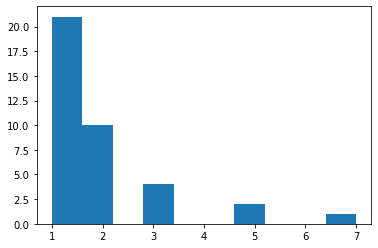

In [11]:
uniuque_top_cows = np.unique(top_cows)
num_tops = np.zeros(len(uniuque_top_cows))
for i, x in enumerate(uniuque_top_cows):
    ii = np.where(top_cows == x)[0]
    #print(f'Tag {int(x)} has the positions {ii}')
    num_tops[i] = len(ii)
print(f'Average apperances: {sum(num_tops)/len(uniuque_top_cows)}')
print(f'Expected appearances if random = ')
num_except_one = []
for i, x in enumerate(num_tops):
    if not(x == 1):
        num_except_one.append(num_tops[i])
print(f'Average apperances when removed ones: {sum(num_except_one)/len(num_except_one)}, which are {len(num_except_one)} out of {len(uniuque_top_cows)}')
plt.hist(num_tops)

In [12]:
def unique(list1):
    unique_list = []
    for i in range(14):
        list2 = list1[i]
        for x in list2:
            if x not in unique_list:
                unique_list.append(x)
    return unique_list

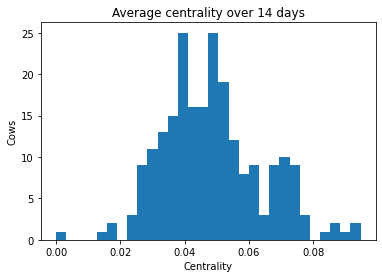

In [24]:
# Creates histogram showing distribution of cows according to Centrality, over 14 days
unique_cows = unique(cow_lists)
unique_times = np.zeros(len(unique_cows))
how_many_days = np.zeros(len(unique_cows))
for i in range(len(data_dict_list)):
    cent = nx.degree_centrality(data_dict_list[i].get('Graph'))
    array = np.array(list(cent.items()))[:,1]
    cow_list = cow_lists[i]
    for j, cow in enumerate(unique_cows):
        k = np.where(cow_list == cow)[0]
        if not (k.size == 0):
            unique_times[j] += array[k]
            how_many_days[j] += 1
unique_times = unique_times/how_many_days
#unique_times = unique_times/len(data_dict_list)
plt.hist(unique_times, bins = 30)
plt.xlabel('Centrality')
plt.ylabel('Cows')
#plt.title('Centrality of Dary cows over 14 days, with 1 days intervals')
plt.title('Average centrality over 14 days')
plt.savefig('./community/Centr/Centrality14days_Adjusted.png')